# Importing libraries

In [6]:
from statsbombpy import sb #pip install statsbombpy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

import warnings
warnings.filterwarnings('ignore') # temporary

# Exploring competions

In [7]:
competitions_df = sb.competitions()

competitions_df.head()

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,16,4,Europe,Champions League,male,False,False,2018/2019,2022-12-01T11:42:34.874323,2021-06-13T16:17:31.694,None,2022-12-01T11:42:34.874323
1,16,1,Europe,Champions League,male,False,False,2017/2018,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2021-01-23T21:55:30.425330
2,16,2,Europe,Champions League,male,False,False,2016/2017,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
3,16,27,Europe,Champions League,male,False,False,2015/2016,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
4,16,26,Europe,Champions League,male,False,False,2014/2015,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00


In [8]:
print('Competions dataframe columns:')
print(competitions_df.columns.tolist())

print('Competitions names:')
print(competitions_df.competition_name.unique())

# The focus of this project is La Liga, so we need the competion id
la_liga_name = 'La Liga'
la_liga_id = competitions_df.query(f'competition_name == "{la_liga_name}"')['competition_id'].iloc[0]
print(f'\nLa Liga competion_id is {la_liga_id}')


Competions dataframe columns:
['competition_id', 'season_id', 'country_name', 'competition_name', 'competition_gender', 'competition_youth', 'competition_international', 'season_name', 'match_updated', 'match_updated_360', 'match_available_360', 'match_available']
Competitions names:
['Champions League' "FA Women's Super League" 'FIFA World Cup'
 'Indian Super league' 'La Liga' 'NWSL' 'Premier League' 'UEFA Euro'
 "UEFA Women's Euro" "Women's World Cup"]

La Liga competion_id is 11


# La Liga seasons exploring

In [9]:
# We need the season_id for each la liga season
print(f'\nLa Liga competion_id is: {la_liga_id}')

seasons_id_list = []

seasons_id_list = competitions_df.query(f'competition_id == {la_liga_id}').season_id.tolist()

print(f'Total seasons of La Liga covered from StatsBomb API: {len(seasons_id_list)}')


La Liga competion_id is: 11
Total seasons of La Liga covered from StatsBomb API: 17


# Collect match data for all sesons

In [11]:
# For how many matches we have information about?
class Season_La_liga():
    def __init__(self, id, name, matches_df):
        self.id = id
        self.name = name
        self.matches_df = matches_df

        self.matches_id_list = self.matches_df.match_id.tolist()

seasons_messi = []

for season in seasons_id_list:
    matches_info_df = sb.matches(competition_id=la_liga_id, season_id=season)
    
    total_season_matches = matches_info_df.shape[0]
    season_name = matches_info_df.season.iloc[0]

    seasons_messi.append(Season_La_liga(season, season_name, matches_info_df))


# Exploring avaliable columns
print(seasons_messi[0].matches_df.columns.tolist())

match_columns_use = ['match_id','match_date', 'season','home_team', 'away_team', 'home_score', 'away_score', 'match_week']

matches_complete_df = pd.DataFrame(columns=match_columns_use)

for messi_season in seasons_messi:
    matches_complete_df = matches_complete_df.append(messi_season.matches_df.loc[:, match_columns_use])

print(matches_complete_df.season.value_counts())

['match_id', 'match_date', 'kick_off', 'competition', 'season', 'home_team', 'away_team', 'home_score', 'away_score', 'match_status', 'match_status_360', 'last_updated', 'last_updated_360', 'match_week', 'competition_stage', 'stadium', 'referee', 'home_managers', 'away_managers', 'data_version', 'shot_fidelity_version', 'xy_fidelity_version']
2014/2015    38
2011/2012    37
2017/2018    36
2020/2021    35
2009/2010    35
2018/2019    34
2016/2017    34
2010/2011    33
2015/2016    33
2019/2020    33
2012/2013    32
2013/2014    31
2008/2009    31
2007/2008    28
2006/2007    26
2005/2006    17
2004/2005     7
Name: season, dtype: int64


# Transforming the match dataframe

In [12]:
matches_complete_df.head()

,match_id,match_date,season,home_team,away_team,home_score,away_score,match_week
0,3773457,2021-05-16,2020/2021,Barcelona,Celta Vigo,1,2,37
1,3773631,2021-02-07,2020/2021,Real Betis,Barcelona,2,3,22
2,3773665,2021-03-06,2020/2021,Osasuna,Barcelona,0,2,26
3,3773497,2021-04-10,2020/2021,Real Madrid,Barcelona,2,1,30
4,3773660,2020-12-13,2020/2021,Barcelona,Levante,1,0,13


In [13]:
def transform_match_dataframe(our_team_name, matches_df):
    matches_df['home/away'] = np.where(matches_df['home_team'] == our_team_name, 'home', 'away')

    matches_df['opponent'] = np.where(matches_df['home_team'] == our_team_name, matches_df['away_team'], matches_df['home_team'])

    matches_df['goals_scored'] = np.where(matches_df['home_team'] == our_team_name, matches_df['home_score'], matches_df['away_score'])

    matches_df['goals_conceded'] = np.where(matches_df['home_team'] == our_team_name, matches_df['away_score'], matches_df['home_score'])

    result_conditions = [
    (matches_df['goals_scored'] > matches_df['goals_conceded']),
    (matches_df['goals_scored'] == matches_df['goals_conceded']),
    (matches_df['goals_scored'] < matches_df['goals_conceded'])
]

    result_values = ['w', 'd', 'l']

    matches_df['result'] = np.select(result_conditions, result_values)

    matches_df['description'] = matches_df['home_team'] + ' - ' + matches_df['away_team'] + ' : ' + matches_df['home_score'].astype(str) + ' - ' \
                                + matches_df['away_score'].astype(str) + ' (' + matches_df['match_date'] + ')'

    matches_df = matches_df.drop(['home_team', 'away_team', 'home_score', 'away_score'], axis=1)

    matches_df = matches_df.sort_values(by=['match_date'])

    # Datatypes of each column
    matches_df.match_id = matches_df.match_id.astype('int64')
    matches_df.match_date = matches_df.match_date.astype('datetime64')
    matches_df.season = matches_df.season.astype('category')
    matches_df.match_week = matches_df.match_week.astype('int32')
    matches_df.goals_scored = matches_df.goals_scored.astype('int32')
    matches_df.goals_conceded = matches_df.goals_conceded.astype('int32')
    matches_df.result = matches_df.result.astype('category')

    return matches_df

matches_df = transform_match_dataframe('Barcelona', matches_complete_df.copy())

# Export matches DataFrame
matches_df.to_csv('all_matches_in_file.csv', index=False)

## Exploring match dataframe

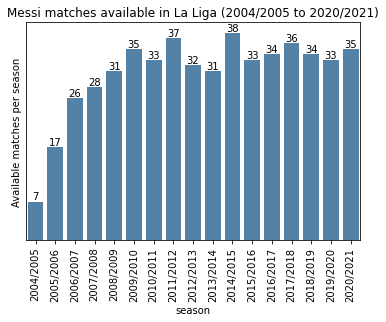

In [14]:
season_match_df = matches_df.groupby('season')[['match_id']].count().reset_index()

ax = sns.barplot(data=season_match_df, x='season', y='match_id', color='steelblue')

plt.xticks(rotation=90);
plt.yticks([])
ax.set_ylabel('Available matches per season')
plt.title('Messi matches available in La Liga (2004/2005 to 2020/2021)')
ax.bar_label(ax.containers[0]);

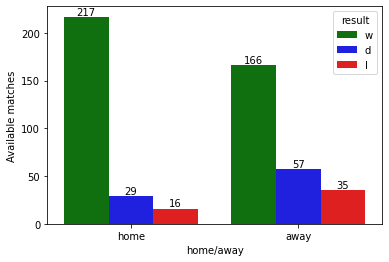

In [15]:
home_away_matches_df = matches_df.groupby(['home/away', 'result'])['match_id'].count().reset_index()

ax = sns.barplot(data=home_away_matches_df, x='home/away', y='match_id', hue='result', order=['home', 'away'], hue_order=['w', 'd', 'l'], palette=['green', 'blue', 'red'])
ax.set_ylabel('Available matches')
for i in range(3):
    ax.bar_label(ax.containers[i]);


# Collecting all shot data from events data

In [16]:
# Exploring avaliable columns
first_season_shots = sb.competition_events(
    country='Spain',
    season='2004/2005',
    division='La Liga',
    split=True
)['shots']

print(first_season_shots.columns.tolist())

def collect_shot_events(seasons_messi_collection):
    shots_columns_to_use  = ['id', 'index', 'period', 'timestamp', 'minute', 'second', 'location', 'player',
                            'possession_team', 'play_pattern', 'duration', 'match_id',
                            'shot_statsbomb_xg', 'shot_outcome', 'shot_type', 'shot_body_part']

    shots_complete_df = pd.DataFrame(columns=shots_columns_to_use)

    for messi_season in seasons_messi_collection:
        print(f'Handling season: {messi_season.name} ...')

        season_shots_df = sb.competition_events(
            country='Spain',
            season=messi_season.name,
            division='La Liga',
            split=True
        )['shots']

        shots_complete_df = shots_complete_df.append(season_shots_df.loc[:, shots_columns_to_use])

    # Transforming the location to x and y coordinates
    shots_complete_df['start_x'] = shots_complete_df.location.str[0]
    shots_complete_df['start_y'] = shots_complete_df.location.str[1]

    shots_complete_df = shots_complete_df.drop(['location'], axis=1)

    # Export option
    shots_complete_df.to_csv('all_shots_in_file.csv', index=False, sep ='\t')

    return shots_complete_df

def import_shot_events():
    shots_imported_df = pd.read_csv('all_shots_in_file.csv')
    return shots_imported_df

def create_df_for_all_shot_events(import_from_file: bool = True):
    if import_from_file is True:
        return import_shot_events()
    
    return collect_shot_events(seasons_messi)


shots_events_df = create_df_for_all_shot_events(False)

print(f'Size of all shots DataFrame : {shots_events_df.shape}')

['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type', 'possession', 'possession_team', 'play_pattern', 'team', 'player', 'position', 'location', 'duration', 'related_events', 'match_id', 'shot_statsbomb_xg', 'shot_end_location', 'shot_key_pass_id', 'shot_first_time', 'shot_outcome', 'shot_type', 'shot_body_part', 'shot_technique', 'shot_freeze_frame', 'possession_team_id', 'player_id', 'shot_one_on_one', 'under_pressure', 'shot_aerial_won', 'out', 'shot_saved_to_post', 'shot_deflected', 'shot_redirect']
Handling season: 2020/2021 ...
Handling season: 2019/2020 ...
Handling season: 2018/2019 ...
Handling season: 2017/2018 ...
Handling season: 2016/2017 ...
Handling season: 2015/2016 ...
Handling season: 2014/2015 ...
Handling season: 2013/2014 ...
Handling season: 2012/2013 ...
Handling season: 2011/2012 ...
Handling season: 2010/2011 ...
Handling season: 2009/2010 ...
Handling season: 2008/2009 ...
Handling season: 2007/2008 ...
Handling season: 2006/2007 ...
Handling seas

# Exploring the shot events DataFrame

In [23]:
shots_transformed_df = shots_events_df.copy()

print(shots_transformed_df.shape)

print(shots_transformed_df.columns)

shots_transformed_df.head()

(12843, 17)
Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'player',
       'possession_team', 'play_pattern', 'duration', 'match_id',
       'shot_statsbomb_xg', 'shot_outcome', 'shot_type', 'shot_body_part',
       'start_x', 'start_y'],
      dtype='object')


,id,index,period,timestamp,minute,second,player,possession_team,play_pattern,duration,match_id,shot_statsbomb_xg,shot_outcome,shot_type,shot_body_part,start_x,start_y
0,ccd059eb-08b6-4f1f-ae13-b1ed2e8f941a,348,1,00:06:55.168,6,55,Pedro González López,Barcelona,From Corner,1.487756,3773457,0.050982,Off T,Open Play,Left Foot,98.9,42.8
1,f4d77b03-6602-4b80-adac-f840ed665451,467,1,00:09:11.887,9,11,Lionel Andrés Messi Cuccittini,Barcelona,Regular Play,0.093700,3773457,0.090202,Blocked,Open Play,Left Foot,105.5,42.9
2,c9e36179-edd5-429c-8004-77b40518c42d,497,1,00:09:32.039,9,32,Antoine Griezmann,Barcelona,Regular Play,0.111788,3773457,0.235028,Saved,Open Play,Left Foot,116.5,31.4
3,c2b6ca56-83f2-4fa0-a175-fada004130c5,734,1,00:14:22.075,14,22,Ousmane Dembélé,Barcelona,From Counter,0.570289,3773457,0.059612,Saved,Open Play,Right Foot,108.0,54.9
4,c56f3aa1-26fe-4e10-a636-0865360df2bc,803,1,00:16:07.677,16,7,Lionel Andrés Messi Cuccittini,Barcelona,Regular Play,0.936565,3773457,0.054610,Off T,Open Play,Left Foot,95.2,41.5


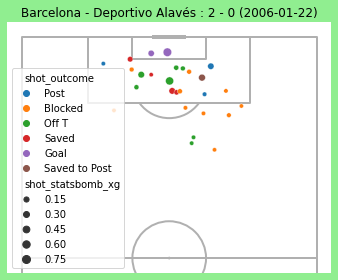

In [24]:
# Explore one match
matches_list = matches_df.match_id.unique().tolist()
ex_match_id = random.choice(matches_list)

match_shots_df = shots_transformed_df.query(f'match_id == {ex_match_id} and possession_team == "Barcelona"')

from mplsoccer.pitch import Pitch, VerticalPitch

# pitch = Pitch(pitch_type='statsbomb', half=True)
pitch = VerticalPitch(pitch_type='statsbomb', half=True)
fig,ax = pitch.draw(figsize=(8, 4))
fig.set_facecolor('lightgreen')

final_score = matches_df.query(f'match_id == {ex_match_id}')['description'].iloc[0]

plt.title(final_score)
# sns.scatterplot(data=match_shots_df, x='start_x', y='start_y', hue='shot_outcome');
sns.scatterplot(data=match_shots_df, x='start_y', y='start_x', hue='shot_outcome', size='shot_statsbomb_xg');


(77, 17)


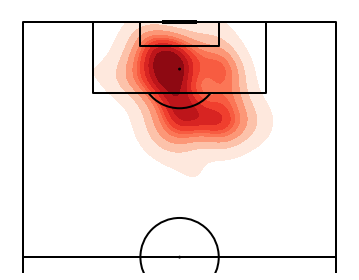

In [25]:
# Get shots from multiple matches
number_of_matches = 20

messi_name = 'Lionel Andrés Messi Cuccittini'

matches_id_collection = random.sample(matches_list, number_of_matches)

match_shots_df = shots_transformed_df.query(f'match_id == {matches_id_collection} and possession_team == "Barcelona" and player == "{messi_name}"')
print(match_shots_df.shape)
pitch = VerticalPitch(pitch_type='statsbomb', half=True, line_zorder=2, line_color='black')
fig,ax = pitch.draw(figsize=(8, 4))

kde = pitch.kdeplot(match_shots_df.start_x, match_shots_df.start_y, ax=ax, fill=True,cmap='Reds', alpha=1, levels=10)

In [26]:
# Test waffle charts
match_shots_df.head()

,id,index,period,timestamp,minute,second,player,possession_team,play_pattern,duration,match_id,shot_statsbomb_xg,shot_outcome,shot_type,shot_body_part,start_x,start_y
228,a76a5818-5463-41c8-b7da-9ef519d501d3,2037,1,00:42:58.037,42,58,Lionel Andrés Messi Cuccittini,Barcelona,From Counter,1.256463,3773672,0.098812,Off T,Open Play,Left Foot,106.9,52.8
234,173e0526-3edb-4068-bf06-fce2a3ff4fbb,3522,2,00:35:52.492,80,52,Lionel Andrés Messi Cuccittini,Barcelona,From Free Kick,0.835239,3773672,0.044297,Saved,Open Play,Left Foot,95.2,32.4
239,103b42bf-2b3e-4810-a309-243fb75d7cf8,4110,2,00:48:24.679,93,24,Lionel Andrés Messi Cuccittini,Barcelona,Regular Play,1.377854,3773672,0.017503,Off T,Open Play,Left Foot,94.0,55.3
466,5f504036-eb84-41fe-b917-13aa6aa32e7b,795,1,00:12:49.635,12,49,Lionel Andrés Messi Cuccittini,Barcelona,Regular Play,1.847193,3773369,0.037070,Goal,Open Play,Left Foot,99.4,33.0
467,ba6f6ebc-334c-40b5-81de-e7fc5543de15,900,1,00:15:31.879,15,31,Lionel Andrés Messi Cuccittini,Barcelona,From Throw In,0.914051,3773369,0.114868,Off T,Open Play,Right Foot,108.0,34.2


77


{'Blocked': 25, 'Off T': 18, 'Saved': 17, 'Goal': 14, 'Post': 3}

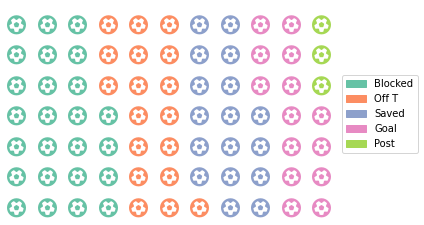

In [60]:
from pywaffle import Waffle

# fig = plt.figure(
#     FigureClass = Waffle,
#     rows = 5,
#     values = match_shots_df.shot_statsbomb_xg,
#     labels = list(match_shots_df.play_pattern.unique())
# )

fig = plt.figure(
    FigureClass= Waffle,
    rows = 7,
    columns = 11,
    values = match_shots_df.shot_outcome.value_counts().to_dict(),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 0.7)},
    icons = 'soccer-ball'
)

print(len(match_shots_df))

match_shots_df.shot_outcome.value_counts().to_dict()

